# Modelo de Optimización con Pyomo


In [2]:

# Importar Bibliotecas
from pyomo.environ import *
import pyomo.opt as opt
from fpdf import FPDF
import pandas as pd

from amplpy import AMPL

# Instanciar el objeto AMPL
ampl = AMPL()

    

In [24]:
# 1: Cargar los parámetros desde el archivo .txt y .xlsx
import ast

parametros = {}
current_key = None
current_value_lines = []

# Abrir y leer el archivo de parámetros
with open('parametros_completos.txt', 'r') as file:
    for line in file:
        line = line.strip()
        if not line or line.startswith('#'):
            # Ignorar líneas vacías o comentarios
            continue
        
        if '=' in line:
            # Procesar el bloque anterior si existe
            if current_key is not None:
                # Unir las líneas acumuladas en un solo string
                value_str = '\n'.join(current_value_lines)
                try:
                    # Usar ast.literal_eval para evaluar de manera segura el valor
                    parametros[current_key] = ast.literal_eval(value_str)
                except (ValueError, SyntaxError):
                    print(f"Error al evaluar la línea: {current_key} = {value_str}")
                    parametros[current_key] = value_str  # Guardar como cadena si falla la evaluación

            # Procesar la nueva línea
            current_key, value_part = line.split('=', 1)
            current_key = current_key.strip()
            current_value_lines = [value_part.strip()]  # Iniciar un nuevo bloque de valor
        else:
            # Continuar acumulando líneas para el valor actual
            current_value_lines.append(line)

    # Procesar el último bloque si existe
    if current_key is not None:
        value_str = '\n'.join(current_value_lines)
        try:
            parametros[current_key] = ast.literal_eval(value_str)
        except (ValueError, SyntaxError):
            print(f"Error al evaluar la línea: {current_key} = {value_str}")
            parametros[current_key] = value_str
            
# Leer el archivo Excel
file_path = 'parametros2.xlsx'

# Leer la hoja de Periodos
df_periodos = pd.read_excel(file_path, sheet_name='Periodos')
T = df_periodos['Periodo'].tolist() 

df_insumos = pd.read_excel(file_path, sheet_name='Insumos')
I = df_insumos['Insumo'].tolist() 

df_productos = pd.read_excel(file_path, sheet_name='Productos')
PT = df_productos['Producto'].tolist()

df_productos = pd.read_excel(file_path, sheet_name='Productos')
PT = df_productos['Producto'].tolist()

# Leer la hoja de Demanda
demand_data = pd.read_excel(file_path, sheet_name='Demanda')
stock_insumos_0 = pd.read_excel(file_path, sheet_name='I_0')

# Convertir el DataFrame de demanda a un diccionario de Pyomo
demand_data = {(row['Producto'], row['Periodo']): row['Demanda'] for index, row in demand_data.iterrows()}
stock_insumos_0 = {(row['Insumo']): row['Cantidad'] for index, row in stock_insumos_0.iterrows()}

# Convertir el DataFrame en un diccionario para Pyomo
cons_data = pd.read_excel(file_path, sheet_name='cons')
cons_dta = {(row['Insumo'], col): row[col] for _, row in cons_data.iterrows() for col in cons_data.columns[1:]}



# 2: Definir los Conjuntos del Modelo de Pyomo
model = ConcreteModel()

# Conjuntos
model.I = Set(initialize=I)
model.PT = Set(initialize=PT)
model.T = Set(initialize=T)

# 3: Definir los Parámetros del Modelo
# Parámetros
pr = parametros['pr']
c = parametros['c']
f = parametros['f']
t = parametros['t']
l = parametros['l']
ss = parametros['ss']
vu = parametros['vu']
q_min = parametros['q_min']
k = parametros['k']
Pal = parametros['Pal']
Pen = parametros['Pen']
#cons = parametros['cons']
PT_0 = parametros['PT_0']
TIE = parametros['TIE']
fecha_actual = parametros['fecha_actual']
k_max = parametros['k_max']
c_prod = parametros['c_prod']
PN = 1000000000  # Penalización por inventario negativo
backorder_cost = parametros['backorder_cost']

# Definición de Parámetros en Pyomo con dominio no negativo
model.d = Param(model.PT, model.T, initialize=demand_data, within=NonNegativeReals)  # Demanda
model.pr = Param(model.I, initialize=lambda model, i: pr[i], within=NonNegativeReals)  # Precio unitario de insumos
model.l = Param(initialize=l, within=NonNegativeReals)  # Lead time como escalar
model.f = Param(initialize=f, within=NonNegativeReals)  # Costo financiero como escalar
model.t_cost = Param(initialize=t, within=NonNegativeReals)  # Costo de transporte por pallet como escalar
model.ss = Param(model.PT, initialize=lambda model, p: ss[p], within=NonNegativeReals)  # Stock de seguridad por producto
model.vu = Param(model.I, initialize=lambda model, i: vu[i], within=NonNegativeReals)  # Vida útil de insumos
model.q_min = Param(model.I, initialize=lambda model, i: q_min[i], within=NonNegativeReals)  # Cantidad mínima de pedido
model.k = Param(initialize=k, within=NonNegativeReals)  # Capacidad del camión
model.Pal = Param(model.I, initialize=lambda model, i: Pal[i], within=NonNegativeReals)  # Cantidad de insumo por pallet
model.Pen = Param(model.I, initialize=lambda model, i: Pen[i], within=NonNegativeReals)  # Penalización
model.cons = Param(model.I, model.PT, initialize=cons_dta, within=NonNegativeReals)  # Consumo de insumo por producto
model.I_0 = Param(model.I, initialize=stock_insumos_0, within=NonNegativeReals)  # Existencias iniciales de insumos
model.PT_0 = Param(model.PT, initialize=lambda model, p: PT_0[p], within=NonNegativeReals)  # Existencias iniciales de productos terminados
model.TIE = Param(initialize=TIE, within=NonNegativeReals)  # Tasa de interés efectiva
model.k_max = Param(initialize=k_max, within=NonNegativeReals)  # Capacidad de procesamiento de fabrica semanal. 
model.c_prod = Param(model.PT, initialize=lambda model, p: c_prod[p], within=NonNegativeReals)  # Costo de producción (solo para restringir producción ilimitada)
model.backorder_cost = Param(model.PT, initialize=lambda model, p: 5.0)  # Costo por backorder

# Step 4: Definir las Variables de Decisión
model.q = Var(model.I, model.T, domain=NonNegativeIntegers, initialize=0)  # Cantidad de pedido
model.x = Var(model.I, model.T, domain=Binary, initialize=0)  # Pedido realizado o no
model.y = Var(model.I, model.T, domain=NonNegativeIntegers, initialize=0)  # Inventario de insumos
model.z = Var(model.I, model.T, domain=NonNegativeIntegers, initialize=0)  # Pallets necesarios
model.y_pt = Var(model.PT, model.T, domain=Reals, initialize=0)  # Inventario de productos terminados
model.penalidad_negativa = Var(model.PT, model.T, within=NonNegativeIntegers, initialize=0)  # Penalización solo es positiva
model.cu = Var(model.T, within=Binary, initialize=0)  # Variable binaria para indicar el uso del camión
model.pro = Var(model.PT, model.T, domain=NonNegativeIntegers, initialize=0)
model.backorder = Var(model.PT, model.T, within=NonNegativeReals)
model.penalidad = Var(model.I, model.T, domain=Binary, initialize=0)  # Penalidad de no cumplir pedido mínimo
model.penalidad2 = Var(model.I, model.T, domain=Binary, initialize=0)  # Penalidad de no cumplir pedido mínimo
model.penalidad3 = Var(model.I, model.T, domain=Binary, initialize=0)  # Penalidad de no cumplir pedido mínimo

In [26]:
# Step 5: Definir la Función Objetivo
def objetivo_rule(model):
    return sum(
        # Costo de mantener inventario de insumos
        model.pr[i] * (c + model.TIE / 52) * model.y[i, t] +  # Costo de almacenamiento 
        model.t_cost * model.cu[t] +  # Costo fijo del camión
        model.Pen[i] * model.penalidad3[i, t] # Penalización por no cumplir pedido mínimo
        for i in model.I for t in model.T
    ) + sum(
        + (c + model.TIE / 52) * c_prod[p] * model.y_pt[p,t]
        + PN * model.penalidad_negativa[p, t] +  # Penalización por inventario negativo de productos
        + model.c_prod[p] * model.pro[p,t]
        + model.backorder_cost[p] * model.backorder[p, t] 
        for p in model.PT for t in model.T

    )
model.objetivo = Objective(rule=objetivo_rule, sense=minimize)


# Step 6: Definir las Restricciones
# Restricción para el inventario inicial de insumos (t = 0)
def inventario_insumos_inicial_rule(model, i):
    return model.y[i, 0] == model.I_0[i]  # Inventario inicial de insumos
model.inventario_insumos_inicial = Constraint(model.I, rule=inventario_insumos_inicial_rule)

# Restricción para el inventario inicial de productos terminados (t = 0)
def inventario_productos_inicial_rule(model, p):
    return model.y_pt[p, 0] == model.PT_0[p]  # Inventario inicial de productos terminados
model.inventario_productos_inicial_rule = Constraint(model.PT, rule=inventario_productos_inicial_rule)

# Restricción para la actualización del inventario de productos terminados (t > 0)
def inventario_productos_actualizacion_rule(model, p, t):
    return model.y_pt[p, t] == model.y_pt[p, t-1] - model.d[p, t-1] + model.pro[p,t-1]
model.inventario_productos_actualizacion = Constraint(model.PT, model.T - {0}, rule=inventario_productos_actualizacion_rule)

# Restricción para definir el inventario total de insumos
def inventario_total_actualizacion_rule(model, i, t):
    conversion_insumos_pt = sum(model.cons[i, p] * model.pro[p, t] for p in model.PT)
    return model.y[i, t] == model.y[i, t-1] + model.q[i,t] - conversion_insumos_pt
model.inventario_total_actualizacion = Constraint(model.I, model.T - {0}, rule=inventario_total_actualizacion_rule)


def capacidad_de_produccion(model, p, t):
    return model.pro[p, t]  <= model.k_max * model.d[p,t]
model.capacidad_produccion = Constraint(model.PT, model.T, rule=capacidad_de_produccion)

def capacidad_camion_rule(model, t):
    return sum(model.z[i, t] for i in model.I) <= model.k * model.cu[t]
model.capacidad_camion = Constraint(model.T, rule=capacidad_camion_rule)

def uso_camion_rule(model, t):
    return model.cu[t] >= sum(model.z[i, t] for i in model.I) / model.k
model.uso_camion = Constraint(model.T, rule=uso_camion_rule)

def pallets_multiples_rule(model, i, t):
    return model.q[i, t] == model.z[i, t] * model.Pal[i]
model.pallets_multiples = Constraint(model.I, model.T, rule=pallets_multiples_rule)

def penalizacion_inventario_negativo_rule(model, p, t):
    return model.penalidad_negativa[p, t] >= -model.y_pt[p, t]
model.penalizacion_inventario_negativo_restriccion = Constraint(model.PT, model.T, rule=penalizacion_inventario_negativo_rule)

def penalizacion_no_negativa_rule(model, p, t):
    return model.penalidad_negativa[p, t] >= 0
model.penalizacion_no_negativa_restriccion = Constraint(model.PT, model.T, rule=penalizacion_no_negativa_rule)

# Modificar la restricción de stock para incluir los backorders
def backorder_penalty_rule(model, p, t):
    # Asegura que el inventario más los backorders cubran el nivel mínimo requerido
    return model.y_pt[p, t] + model.backorder[p, t] >= model.ss[p] + model.l * model.d[p, t]
model.BackorderPenalty = Constraint(model.PT, model.T, rule=backorder_penalty_rule)

def penalidad_rule(model, i, t):
    return model.penalidad[i, t] * 10000000000 >= model.q_min[i] - model.q[i, t]  

model.penalidad_restriccion = Constraint(model.I, model.T, rule=penalidad_rule)

def penalidad_rule2(model, i, t):
    return model.penalidad2[i, t] * 10000000000 >=  model.q[i, t]  

model.penalidad_restriccion2 = Constraint(model.I, model.T, rule=penalidad_rule2)

def penalidad_rule3(model, i, t):
    return    model.penalidad3[i, t] >= model.penalidad[i, t] - model.penalidad2[i, t]

model.penalidad_restriccion3 = Constraint(model.I, model.T, rule=penalidad_rule3)


def penalidad_minima_rule(model, i, t):
    return model.penalidad[i, t] >= 0
model.penalidad_minima_restriccion = Constraint(model.I, model.T, rule=penalidad_minima_rule)


Restricted license - for non-production use only - expires 2025-11-24
Read LP format model from file /var/folders/0p/s6c7y_lj66q92j49z14qm1vh0000gn/T/tmpyifjwagx.pyomo.lp
Reading time = 0.01 seconds
x1: 1995 rows, 1785 columns, 4429 nonzeros
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[x86] - Darwin 21.6.0 21G115)

CPU model: Intel(R) Core(TM) i5-8210Y CPU @ 1.60GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 1995 rows, 1785 columns and 4429 nonzeros
Model fingerprint: 0x9025a16f
Variable types: 378 continuous, 1407 integer (525 binary)
Coefficient statistics:
  Matrix range     [4e-02, 1e+10]
  Objective range  [1e-04, 1e+09]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+02, 3e+05]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 1824 rows and 1520 columns
Presolve time: 0.05s
Presolved: 171 rows, 265 columns, 564 nonzeros
Variable ty

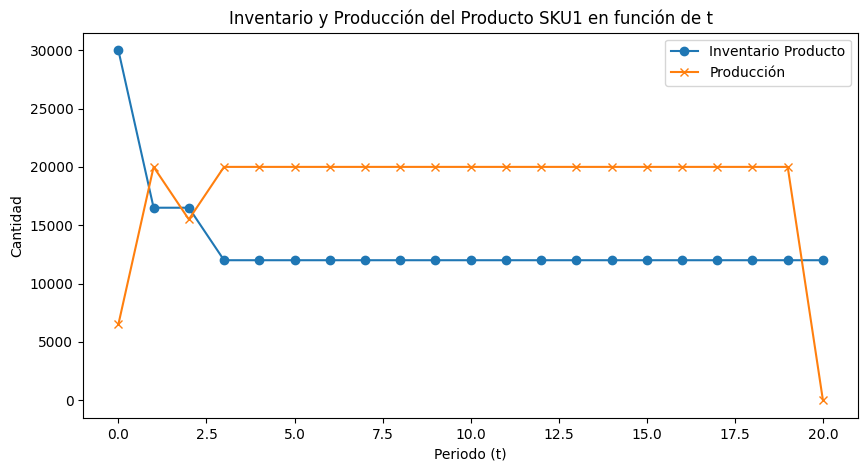

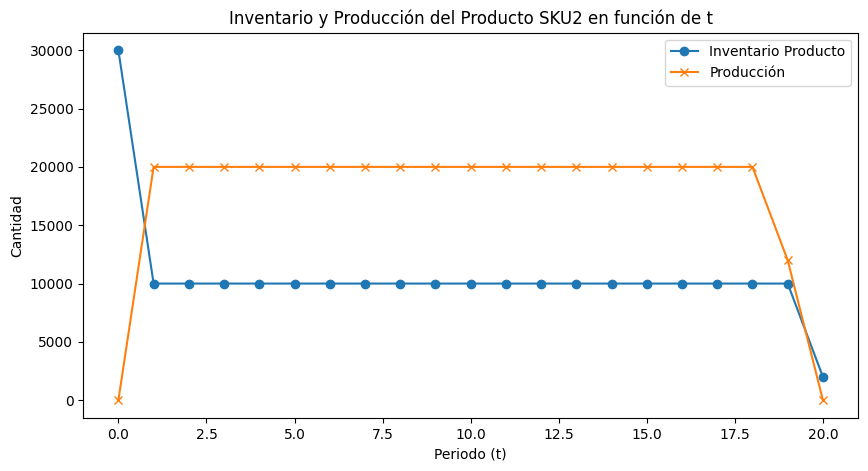

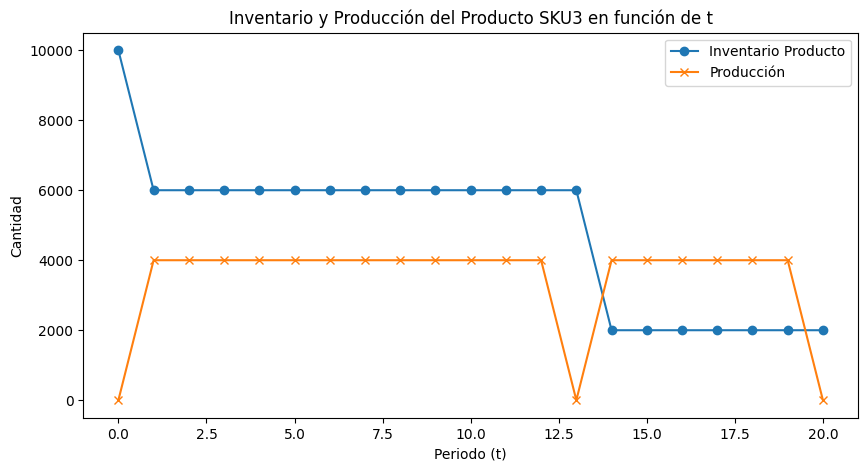

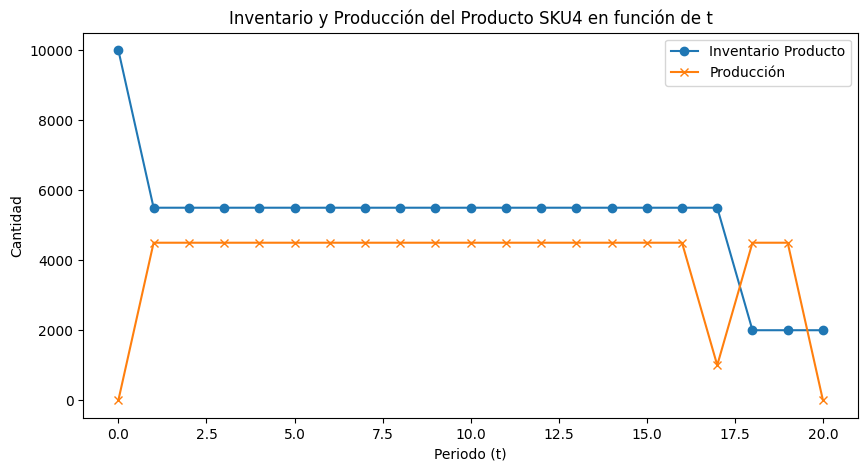

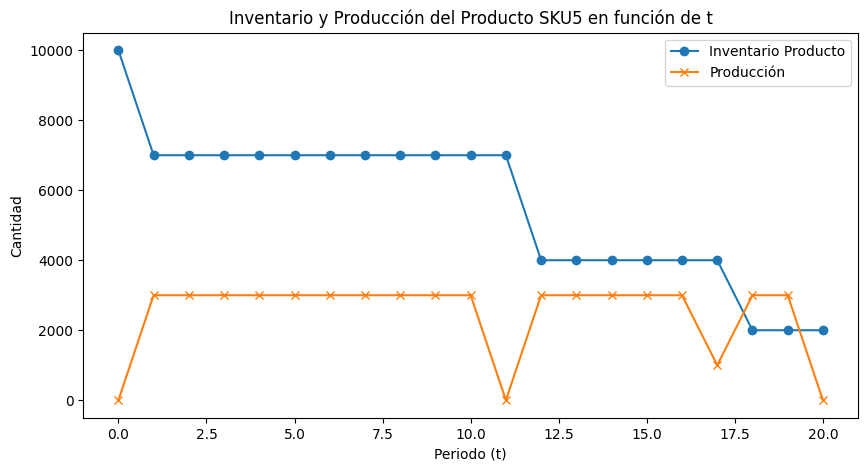

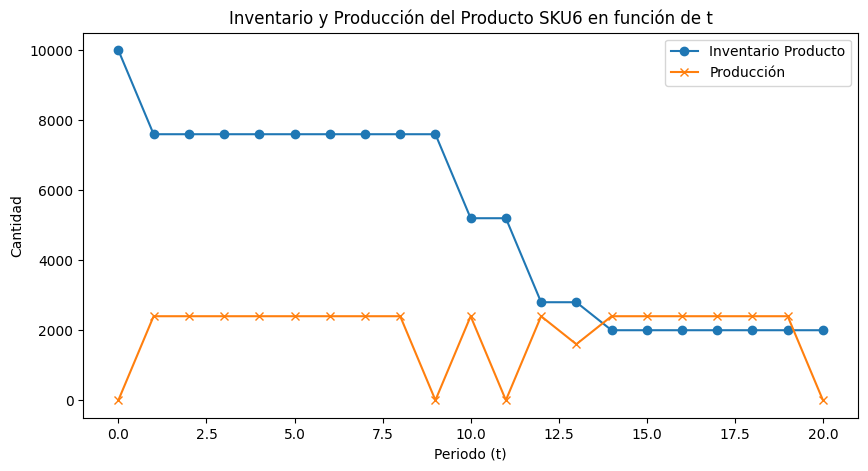

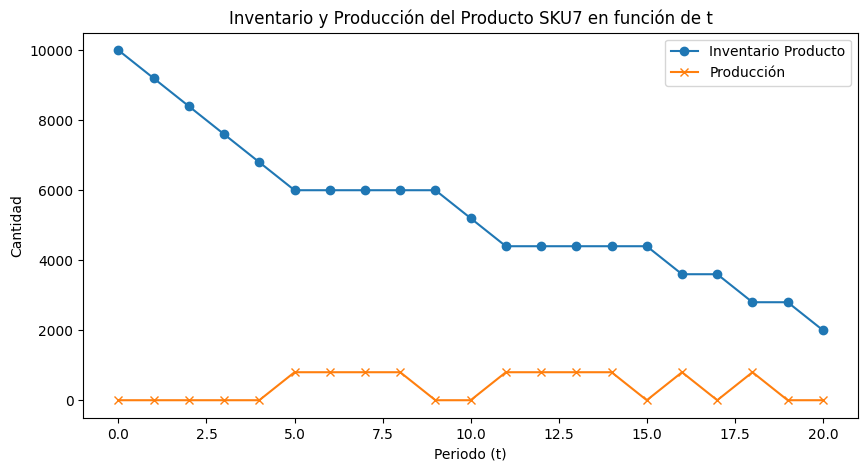

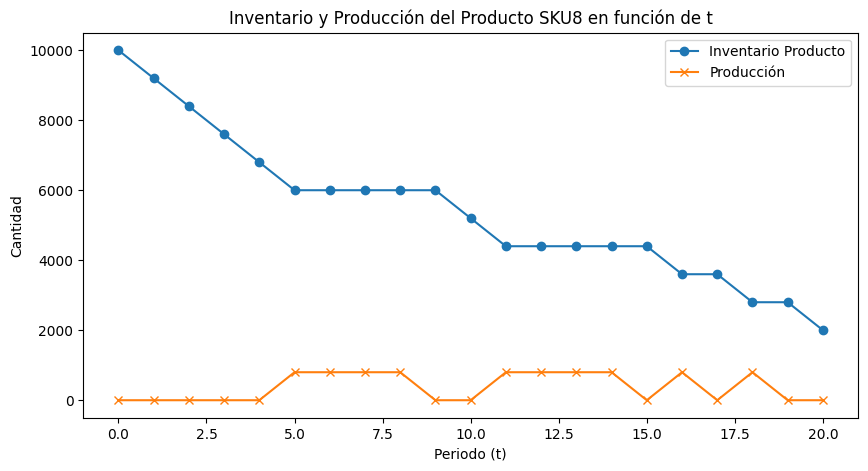

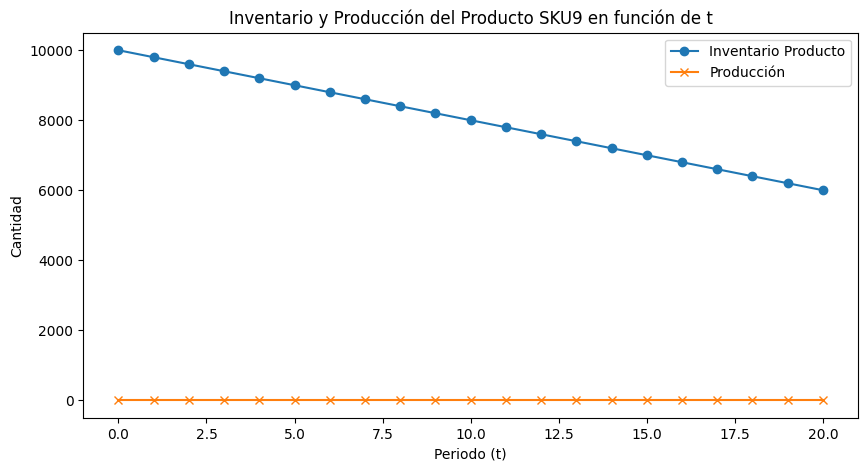

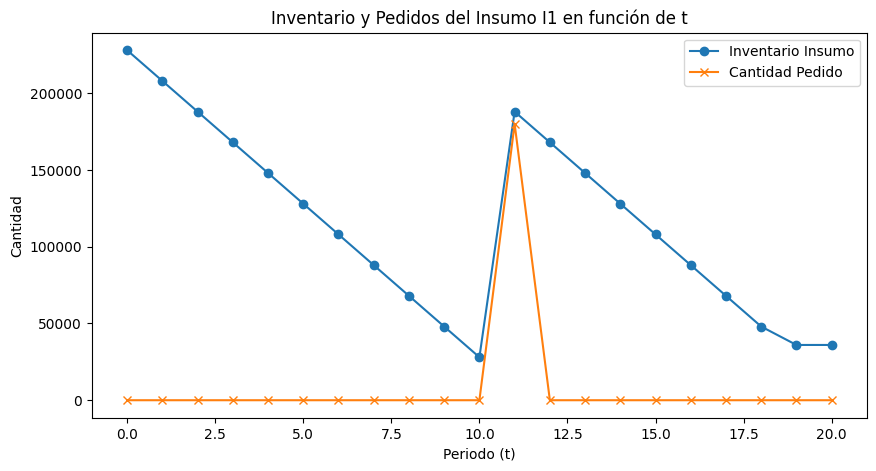

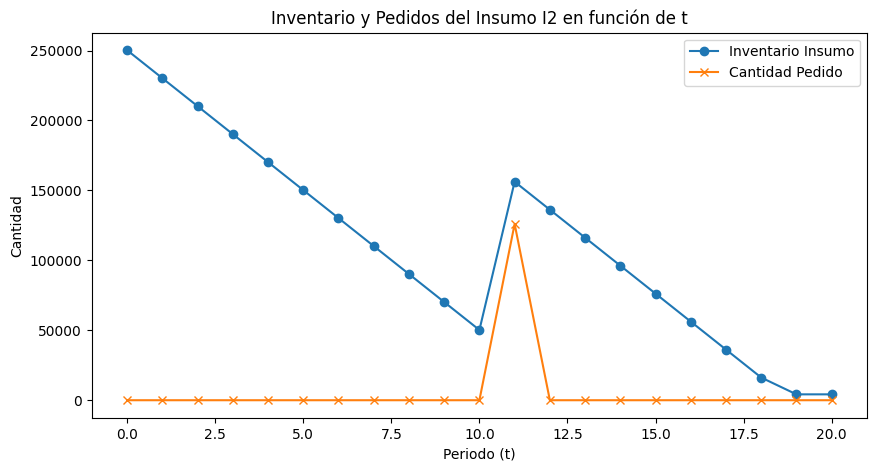

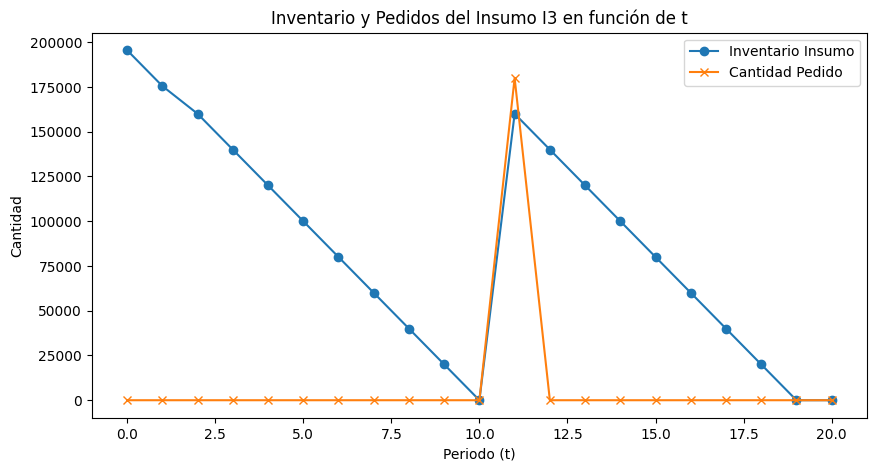

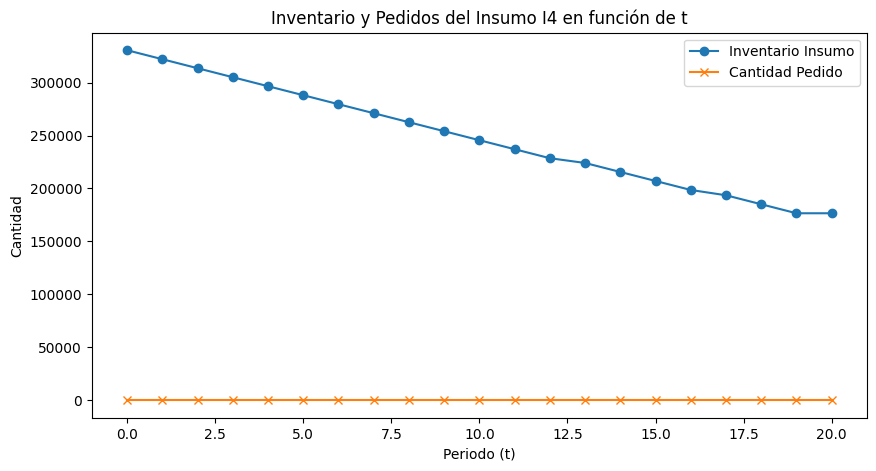

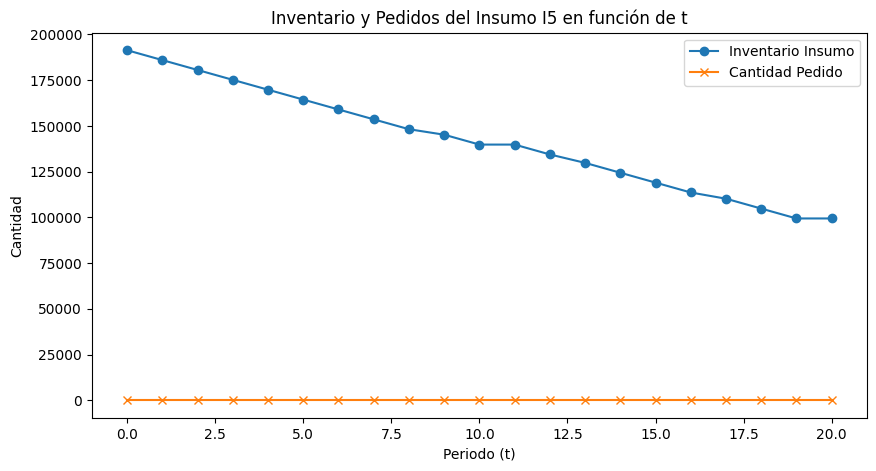

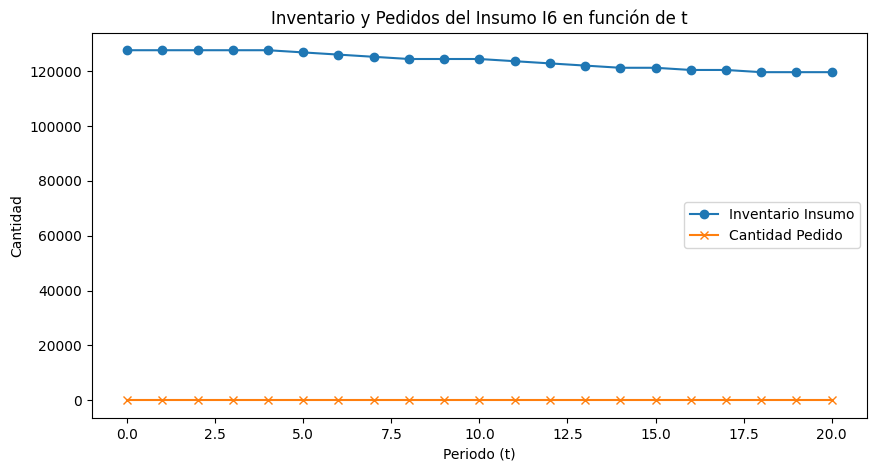

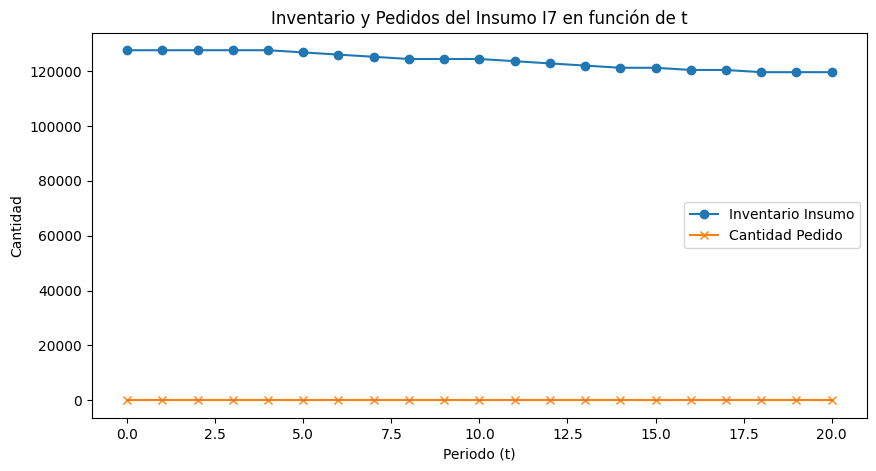

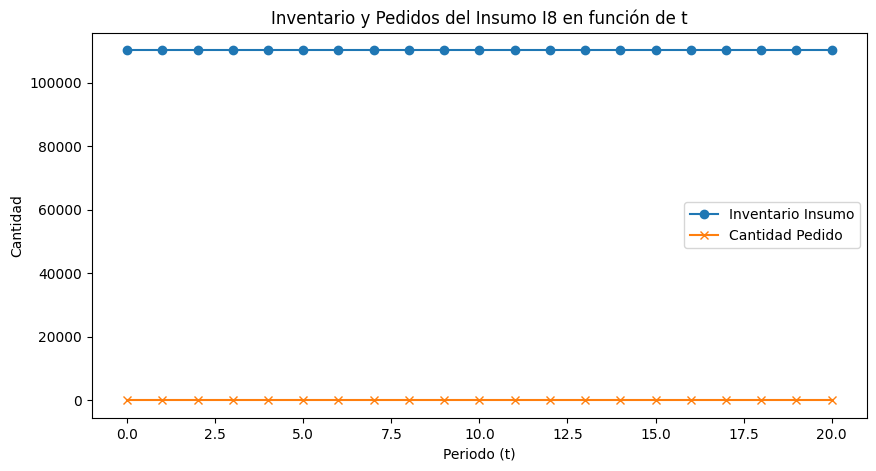

In [28]:
import matplotlib.pyplot as plt

# Solución del modelo
solver = SolverFactory('gurobi')
# Configurar el tiempo límite (en segundos)
#solver.options['tmlim'] = 60


results = solver.solve(model, tee=True)

# Guardar la solución en un archivo .json
results.write(filename='solucion_modelo.json', format='json')

# Chequeo del estado de optimización
print("Estado de optimización:", results.solver.termination_condition)
if results.solver.termination_condition == TerminationCondition.infeasible:
    print("El modelo es infeasible. Revisa los parámetros y las restricciones.")
else:
    # Step 8: Guardar Resultados en DataFrames
    pedidos = []
    inventarios_insumos = []
    inventarios_productos = []
    camiones_usados = []
    produccion_productos = []

    for i in model.I:
        for t in model.T:
            pedidos.append({'Insumo': i, 'Periodo': t, 'Cantidad Pedido': model.q[i, t].value})
            inventarios_insumos.append({'Insumo': i, 'Periodo': t, 'Inventario Insumo': model.y[i, t].value})

    for p in model.PT:
        for t in model.T:
            inventarios_productos.append({'Producto': p, 'Periodo': t, 'Inventario Producto': model.y_pt[p, t].value})
            produccion_productos.append({'Producto': p, 'Periodo': t, 'Producción': model.pro[p, t].value})

    for t in model.T:
        camiones_usados.append({'Periodo': t, 'Camiones Usados': model.cu[t].value})

    # Convertir listas a DataFrames
    df_pedidos = pd.DataFrame(pedidos)
    df_inventarios_insumos = pd.DataFrame(inventarios_insumos)
    df_inventarios_productos = pd.DataFrame(inventarios_productos)
    df_produccion_productos = pd.DataFrame(produccion_productos)
    df_camiones_usados = pd.DataFrame(camiones_usados)

    # Exportar a archivo Excel
    with pd.ExcelWriter('solucion_modelo.xlsx') as writer:
        df_pedidos.to_excel(writer, sheet_name='Pedidos', index=False)
        df_inventarios_insumos.to_excel(writer, sheet_name='Inventarios Insumos', index=False)
        df_inventarios_productos.to_excel(writer, sheet_name='Inventarios Productos', index=False)
        df_produccion_productos.to_excel(writer, sheet_name='Producción Productos', index=False)
        df_camiones_usados.to_excel(writer, sheet_name='Camiones Usados', index=False)

    # Mostrar resultados
    print("Costo total mínimo:", model.objetivo())

    # Graficar inventario y producción de productos terminados en función de t
    for p in model.PT:
        plt.figure(figsize=(10, 5))
        plt.plot(df_inventarios_productos[df_inventarios_productos['Producto'] == p]['Periodo'],
                 df_inventarios_productos[df_inventarios_productos['Producto'] == p]['Inventario Producto'],
                 marker='o', label='Inventario Producto')
        plt.plot(df_produccion_productos[df_produccion_productos['Producto'] == p]['Periodo'],
                 df_produccion_productos[df_produccion_productos['Producto'] == p]['Producción'],
                 marker='x', label='Producción')
        plt.title(f'Inventario y Producción del Producto {p} en función de t')
        plt.xlabel('Periodo (t)')
        plt.ylabel('Cantidad')
        plt.legend()
        plt.show()

    # Graficar inventario y pedidos de insumos en función de t
    for i in model.I:
        plt.figure(figsize=(10, 5))
        plt.plot(df_inventarios_insumos[df_inventarios_insumos['Insumo'] == i]['Periodo'],
                 df_inventarios_insumos[df_inventarios_insumos['Insumo'] == i]['Inventario Insumo'],
                 marker='o', label='Inventario Insumo')
        plt.plot(df_pedidos[df_pedidos['Insumo'] == i]['Periodo'],
                 df_pedidos[df_pedidos['Insumo'] == i]['Cantidad Pedido'],
                 marker='x', label='Cantidad Pedido')
        plt.title(f'Inventario y Pedidos del Insumo {i} en función de t')
        plt.xlabel('Periodo (t)')
        plt.ylabel('Cantidad')
        plt.legend()
        plt.show()


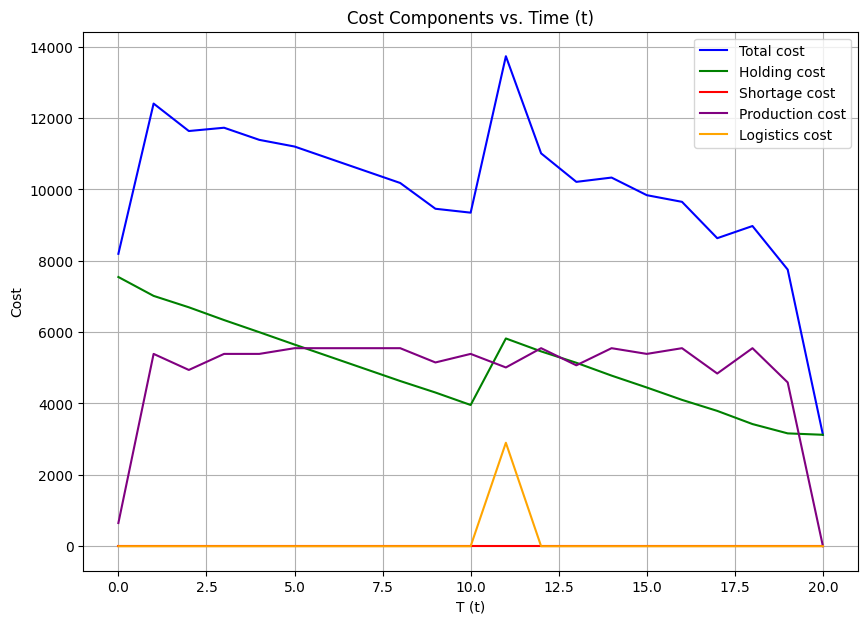

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Definir los períodos t a graficar
T_values = list(model.T)

# Inicializar listas para los diferentes costos por cada período t
#fixed_costs = []  
holding_costs = []  
shortage_costs = []  
production_costs = []  
logistics_costs = []  
total_costs = []  

# Calcular los costos para cada período t
for t in T_values:
    #fixed_cost = model.t_cost * model.cu[t].value  # Costo fijo/logístico asociado al uso de camiones
    holding_cost = sum(c * model.y[i, t].value + c * model.y_pt[p, t].value for i in model.I for p in model.PT)
    shortage_cost = sum(Pen[i] * model.penalidad3[i, t].value for i in model.I) + sum(PN * model.penalidad_negativa[p, t].value for p in model.PT)
    production_cost = sum(c_prod[p] * model.pro[p, t].value for p in model.PT)
    logistics_cost = model.t_cost * model.cu[t].value  # Costo logístico, igual que el costo fijo en este caso
    
    total_cost = holding_cost + shortage_cost + production_cost + logistics_cost

    # Almacenar los resultados
    #fixed_costs.append(fixed_cost)
    holding_costs.append(holding_cost)
    shortage_costs.append(shortage_cost)
    production_costs.append(production_cost)
    logistics_costs.append(logistics_cost)
    total_costs.append(total_cost)

# Graficar los resultados
plt.figure(figsize=(10, 7))

plt.plot(T_values, total_costs, label='Total cost', color='blue')
plt.plot(T_values, holding_costs, label='Holding cost', color='green')
#plt.plot(T_values, fixed_costs, label='Fixed cost', color='black')
plt.plot(T_values, shortage_costs, label='Shortage cost', color='red')
plt.plot(T_values, production_costs, label='Production cost', color='purple')
plt.plot(T_values, logistics_costs, label='Logistics cost', color='orange')

plt.xlabel('T (t)')
plt.ylabel('Cost')
plt.title('Cost Components vs. Time (t)')
plt.legend()
plt.grid(True)
plt.show()


In [216]:
from fpdf import FPDF
from datetime import datetime, timedelta

# Paso 1: Crear la clase PDF
class PDF(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, 'Orden de Compra', 0, 1, 'C')
        self.ln(10)

    def footer(self):
        self.set_y(-15)
        self.set_font('Arial', 'I', 8)
        self.cell(0, 10, f'Página {self.page_no()}', 0, 0, 'C')

# Paso 2: Crear la función para generar el PDF
def generar_orden_compra(model, fecha_inicio):
    # Encontrar el primer periodo en el que se utiliza un camión
    periodo_orden = None
    for t in model.T:
        if model.cu[t].value > 0:  # Si un camión es usado en este período
            periodo_orden = t
            break

    if periodo_orden is None:
        print("No hay ningún período con uso de camión.")
        return

    # Calcular la semana del año correspondiente al período de orden
    fecha_inicio = datetime.strptime(fecha_inicio, "%Y-%m-%d")
    fecha_periodo = fecha_inicio + timedelta(weeks=periodo_orden)
    semana_del_anio = fecha_periodo.isocalendar()[1]

    # Calcular el primer día (lunes) de esa semana del año
    primer_dia_semana = fecha_periodo - timedelta(days=fecha_periodo.weekday())

    pdf = PDF()
    pdf.add_page()
    pdf.set_font('Arial', 'B', 12)
    pdf.cell(0, 10, f'Orden de Compra - Semana {semana_del_anio} del Año {fecha_periodo.year} (Inicio: {primer_dia_semana.strftime("%d/%m/%Y")})', 0, 1)
    pdf.ln(5)
    
    # Encabezados de la tabla
    pdf.set_font('Arial', 'B', 10)
    pdf.cell(60, 10, 'Insumo', 1)  # Aumentar el ancho de la celda para descripciones largas
    pdf.cell(30, 10, 'Precio Unitario', 1)
    pdf.cell(30, 10, 'Cantidad a Ordenar', 1)
    pdf.cell(30, 10, 'Total por Insumo', 1)
    pdf.ln()

    # Paso 3: Iterar sobre los insumos y agregar las cantidades a ordenar para el primer periodo con camión usado
    pdf.set_font('Arial', '', 10)
    total_pagar = 0  # Variable para almacenar el total a pagar

    for i in model.I:
        cantidad_ordenar = model.q[i, periodo_orden].value
        precio_unitario = model.pr[i]  # Asumimos que 'p' es el parámetro de precio unitario de cada insumo
        total_insumo = precio_unitario * cantidad_ordenar
        
        if cantidad_ordenar > 0:  # Agregar solo si hay una cantidad a ordenar
            pdf.cell(60, 10, i, 1)  # Ajuste de ancho para descripciones largas
            pdf.cell(30, 10, f'{precio_unitario:.2f}', 1)
            pdf.cell(30, 10, f'{cantidad_ordenar:.2f}', 1)
            pdf.cell(30, 10, f'{total_insumo:.2f}', 1)
            pdf.ln()
            total_pagar += total_insumo  # Sumar al total a pagar

    # Paso 4: Imprimir el Total a Pagar
    pdf.set_font('Arial', 'B', 10)
    pdf.cell(120, 10, 'Total a Pagar', 1)
    pdf.cell(30, 10, f'{total_pagar:.2f}', 1)
    pdf.ln()

    # Paso 5: Guardar el PDF
    pdf_output_path = 'orden_de_compra_periodo_{}.pdf'.format(periodo_orden)
    pdf.output(pdf_output_path)
    print(f"Orden de compra guardada como {pdf_output_path}")

# Paso 6: Generar el PDF para el primer período con uso de camión, incluyendo la fecha de inicio del análisis
generar_orden_compra(model, fecha_actual)


Orden de compra guardada como orden_de_compra_periodo_11.pdf
